In [ ]:
"""
Для загрузки ohlcv данных можено использовать скрипт fetch_ohlcv.py из этого же репозитория.
Пример использования: python fetch_ohlcv.py -I 5m -N 110000 -o btc_coinbase_5m_110k.csv.

python fetch_ohlcv.py [-N NUM] [-T TICKER] [-I INTERVAL] [-o FILE]
Параметры:
-N Количество записей (по умолчанию: 10000)
-T Торговая пара (по умолчанию: BTC/USDT)
-I Таймфрейм (1m, 5m, 1h и т.д.) (по умолчанию: 5m)
-o Выходной CSV файл (если не указан - вывод в консоль)

Мне удалось добиться RoC-AUC=64 , за счет добавления 37 новых индикаторов, часть взяты из примера в уроке, часть выявлены мною.
Что примечательно для таймфрейма 5m  RoC-AUC меньше, чем для 1m. Хотя во втором случае зашумленность выше.

Буду рад предложениям по улучшению в рамках текущей модели.
Может быть использовать ансамбли моделей – CatBoost, LightGBM + XGBoost.
Или добавить еще фичей
"""

In [179]:
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from scipy import stats
import pandas as pd

import numpy as np
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.preprocessing import MinMaxScaler
import ccxt
import time
from sklearn.model_selection import train_test_split


In [87]:
import warnings
warnings.filterwarnings('ignore')

In [88]:
from IPython.core.display import display, HTML
display(HTML("<style>.container { width:90% !important; }</style>"))

In [327]:
df = pd.read_csv('btc_coinbase_66k.csv')
df['time'] = pd.to_datetime(df['timestamp'], unit='ms').dt.tz_localize('UTC')

df

,timestamp,open,high,low,close,volume,datetime,time
0,1740966900000,93017.50,93142.75,93017.50,93142.75,0.282107,2025-03-03 01:55:00,2025-03-03 01:55:00+00:00
1,1740966960000,93095.50,93110.22,92998.61,92998.61,0.042215,2025-03-03 01:56:00,2025-03-03 01:56:00+00:00
2,1740967020000,93031.88,93101.21,93023.38,93088.10,0.771525,2025-03-03 01:57:00,2025-03-03 01:57:00+00:00
3,1740967140000,93053.26,93100.55,93053.26,93100.55,0.079090,2025-03-03 01:59:00,2025-03-03 01:59:00+00:00
4,1740967200000,93132.72,93172.46,93032.16,93032.16,0.279609,2025-03-03 02:00:00,2025-03-03 02:00:00+00:00
...,...,...,...,...,...,...,...,...
65997,1746965940000,104713.60,104713.60,104692.56,104692.56,0.040394,2025-05-11 12:19:00,2025-05-11 12:19:00+00:00
65998,1746966060000,104716.27,104728.60,104701.89,104701.89,0.075370,2025-05-11 12:21:00,2025-05-11 12:21:00+00:00
65999,1746966120000,104659.58,104674.28,104659.58,104674.28,0.061453,2025-05-11 12:22:00,2025-05-11 12:22:00+00:00
66000,1746966360000,104732.32,104732.32,104661.94,104661.94,0.040188,2025-05-11 12:26:00,2025-05-11 12:26:00+00:00


## Генерация фичей

<Axes: >

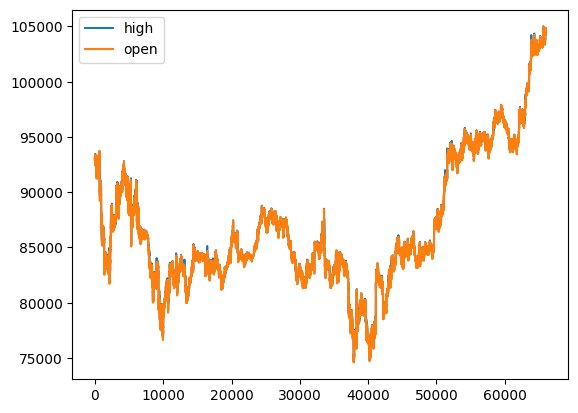

In [328]:
df[['high', 'open']].plot()

In [329]:
# Фичи сезонности

df['year']=df['time'].dt.strftime('%Y')
df['month']=df['time'].dt.strftime('%m')
df['day']=df['time'].dt.strftime('%d')
df['year_month']=df['time'].dt.strftime('%Y_%m')
df['hour']=df['time'].dt.strftime('%H')
df['minute']=df['time'].dt.strftime('%M')

## BaseLine

In [334]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np

import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score, precision_score, recall_score
import numpy as np
from matplotlib import  pyplot as plt

# Функция для добавления целевой переменной (таргета)
def add_target(df):
    df['close_next_hour'] = df['close'].shift(-15)
    df['target'] = (df['close_next_hour'] > df['close']).astype(int)
    df = df.dropna(subset=['close_next_hour'])
    
    return df

# Первый метод: фильтрация строк, где таргет не определён (например, NaN в close_next_hour)
def filter_invalid_targets(df):
    # Удаляем строки, где close_next_hour или target равен NaN
    return df.dropna(subset=['close_next_hour', 'target'])



## Трендовые фичи и тех. индикаторы

In [335]:
import talib

In [336]:
def create_trend_features(df, features, lag_periods):
    """
    Добавляет классические финансовые признаки: отношение к предыдущим периодам, логарифмические изменения и индикаторы трендов.
    
    df: DataFrame с исходными данными
    features: список признаков, для которых необходимо добавить индикаторы
    lag_periods: сколько периодов назад учитывать для расчетов
    
    Возвращает:
    - обновленный DataFrame с новыми фичами
    - список новых колонок, которые можно использовать как признаки
    """
    df = df.copy()  # Работаем с копией DataFrame
    new_columns = []  # Список для хранения новых колонок
    
    for feature in features:
        # Отношение текущего значения к предыдущему (лаг = 1)
        df[f'{feature}_ratio_1'] = df[feature] / df[feature].shift(1)
        new_columns.append(f'{feature}_ratio_1')
        
        # Логарифмическое изменение (логарифм отношения текущего значения к предыдущему)
        df[f'{feature}_log_diff_1'] = np.log(df[feature] / df[feature].shift(1))
        new_columns.append(f'{feature}_log_diff_1')
        
        # Momentum (разница между текущим значением и значением N периодов назад)
        df[f'{feature}_momentum_{lag_periods}'] = df[feature] - df[feature].shift(lag_periods)
        new_columns.append(f'{feature}_momentum_{lag_periods}')
        
        # Rate of Change (ROC): процентное изменение за N периодов
        df[f'{feature}_roc_{lag_periods}'] = (df[feature] - df[feature].shift(lag_periods)) / df[feature].shift(lag_periods) * 100
        new_columns.append(f'{feature}_roc_{lag_periods}')
        
        # Exponential Moving Average (EMA) с периодом N
        df[f'{feature}_ema_{lag_periods}'] = df[feature].ewm(span=lag_periods, adjust=False).mean()
        new_columns.append(f'{feature}_ema_{lag_periods}')

    df['returns'] = df['close'].pct_change()  # Процентные изменения

        
    df['rsi_14'] = talib.RSI(df['close'], timeperiod=14)  # RSI
    df['boll_upper'], df['boll_mid'], df['boll_lower'] = talib.BBANDS(df['close'])  # Bollinger Bands
    df['atr_14'] = talib.ATR(df['high'], df['low'], df['close'], timeperiod=14) 
        
    # Фичи объема
    df['volume_ma_20'] = talib.SMA(df['volume'], timeperiod=20)
    df['volume_change'] = df['volume'].pct_change()

    # Фичи свечных паттернов
    df['doji'] = talib.CDLDOJI(df['open'], df['high'], df['low'], df['close'])  # Дожи
    df['engulfing'] = talib.CDLENGULFING(df['open'], df['high'], df['low'], df['close'])  # Поглощение

    # Фичи волатильности
    df['rolling_vol_10'] = df['returns'].rolling(10).std()  # Историческая волатильность
    df['range'] = df['high'] - df['low']  # Диапазон свечи
    df['range_pct'] = df['range'] / df['close']  # Относительный диапазон

    new_columns.extend(['returns', 'rsi_14', 'boll_upper', 'atr_14', 
                            'volume_ma_20', 'volume_change', 'doji', 'engulfing', 
                            'rolling_vol_10', 'range', 'range_pct'])
    
    # Удаление строк с NaN значениями, которые появились из-за сдвигов
    df = df.dropna()
    
    return df, new_columns


In [337]:
def create_macd(df, feature, short_window=12, long_window=26):
    """
    Добавляет индикатор MACD (разница между краткосрочным и долгосрочным EMA).
    
    df: DataFrame с исходными данными
    feature: признак, для которого необходимо рассчитать MACD
    short_window: окно для краткосрочного EMA (по умолчанию 12)
    long_window: окно для долгосрочного EMA (по умолчанию 26)
    
    Возвращает:
    - обновленный DataFrame с MACD
    - название новой колонки с MACD
    """
    df = df.copy()
    
    # Рассчитываем краткосрочное и долгосрочное EMA
    ema_short = df[feature].ewm(span=short_window, adjust=False).mean()
    ema_long = df[feature].ewm(span=long_window, adjust=False).mean()
    
    # Разница между краткосрочным и долгосрочным EMA (MACD)
    df[f'{feature}_macd'] = ema_short - ema_long
    
    return df, f'{feature}_macd'

In [338]:
# new_trend_features = []

# Добавляем целевую переменную (таргет)
data = filter_invalid_targets(add_target(df))

# Параметры для создания трендовых признаков
lag_periods = 5 # Например, 3 периода назад
features_to_trend = ['open', 'high', 'low', 'close', 'volume']

# Создаем трендовые признаки
data_with_trend, new_trend_features = create_trend_features(data, features_to_trend, lag_periods)

# Добавляем MACD для признака 'close'
data_with_trend, macd_column = create_macd(data_with_trend, 'close')

# Добавляем название колонки с MACD в список новых фичей
new_trend_features.append(macd_column)

In [339]:
len(new_trend_features)

37

In [340]:
new_trend_features

['open_ratio_1',
 'open_log_diff_1',
 'open_momentum_5',
 'open_roc_5',
 'open_ema_5',
 'high_ratio_1',
 'high_log_diff_1',
 'high_momentum_5',
 'high_roc_5',
 'high_ema_5',
 'low_ratio_1',
 'low_log_diff_1',
 'low_momentum_5',
 'low_roc_5',
 'low_ema_5',
 'close_ratio_1',
 'close_log_diff_1',
 'close_momentum_5',
 'close_roc_5',
 'close_ema_5',
 'volume_ratio_1',
 'volume_log_diff_1',
 'volume_momentum_5',
 'volume_roc_5',
 'volume_ema_5',
 'returns',
 'rsi_14',
 'boll_upper',
 'atr_14',
 'volume_ma_20',
 'volume_change',
 'doji',
 'engulfing',
 'rolling_vol_10',
 'range',
 'range_pct',
 'close_macd']

In [341]:
data = data_with_trend[new_trend_features + ['target', 'time']]
data

,open_ratio_1,open_log_diff_1,open_momentum_5,open_roc_5,open_ema_5,high_ratio_1,high_log_diff_1,high_momentum_5,high_roc_5,high_ema_5,...,volume_ma_20,volume_change,doji,engulfing,rolling_vol_10,range,range_pct,close_macd,target,time
19,1.000578,0.000578,88.39,0.095148,92944.400599,1.000139,0.000139,81.69,0.087898,92988.144247,...,0.317283,-0.772007,100,0,0.000473,39.60,0.000426,0.000000,0,2025-03-03 02:15:00+00:00
20,0.999609,-0.000391,17.31,0.018627,92946.007066,0.999249,-0.000751,17.31,0.018627,92975.169498,...,0.311233,-0.160471,0,0,0.000774,127.18,0.001370,-13.337094,0,2025-03-03 02:16:00+00:00
21,0.999166,-0.000835,40.76,0.043908,92921.224711,0.999166,-0.000835,-78.34,-0.084282,92940.666332,...,0.311389,-0.718612,0,0,0.000705,47.83,0.000515,-23.598497,0,2025-03-03 02:17:00+00:00
22,0.999323,-0.000678,-166.94,-0.179552,92883.733141,1.000084,0.000084,-96.24,-0.103511,92920.260888,...,0.280464,2.374965,0,0,0.000728,70.71,0.000761,-27.688445,0,2025-03-03 02:18:00+00:00
23,1.001135,0.001134,-17.76,-0.019111,92893.848760,1.000446,0.000446,-85.26,-0.091671,92920.457259,...,0.283620,-0.070524,100,0,0.000727,20.94,0.000225,-26.997112,1,2025-03-03 02:19:00+00:00
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65982,1.000536,0.000535,21.74,0.020809,104468.279932,1.000581,0.000581,23.04,0.022052,104474.618490,...,0.099827,0.247870,0,0,0.000324,9.33,0.000089,-3.461601,1,2025-05-11 11:51:00+00:00
65983,1.000140,0.000140,21.01,0.020107,104483.069955,1.000140,0.000140,-12.80,-0.012245,104488.988994,...,0.099186,0.128989,0,0,0.000328,5.08,0.000049,1.254400,1,2025-05-11 11:54:00+00:00
65984,1.000913,0.000912,122.78,0.117509,104524.719970,1.001461,0.001460,185.21,0.177259,104549.475996,...,0.077170,1.613416,0,0,0.000542,62.43,0.000596,17.197541,1,2025-05-11 11:56:00+00:00
65985,1.000565,0.000565,224.94,0.215373,104572.193313,1.000052,0.000052,233.66,0.223722,104591.603997,...,0.063298,-0.857982,0,0,0.000528,11.93,0.000114,28.972509,0,2025-05-11 11:57:00+00:00


## Samples split

In [342]:
def split_dataframe(
    df: pd.DataFrame,
    target_column: str = None,
    train_size: float = 0.7,
    val_size: float = 0.15,
    test_size: float = 0.15,
    random_state: int = None,
    stratify: bool = False
) -> tuple:
    """
    Разделяет DataFrame на обучающую, валидационную и тестовую выборки.
    
    Параметры:
    -----------
    df : pd.DataFrame
        Исходный DataFrame для разделения
    target_column : str, optional
        Столбец для стратифицированного разделения (если None - случайное)
    train_size : float, default 0.7
        Доля обучающей выборки (0.0 - 1.0)
    val_size : float, default 0.15
        Доля валидационной выборки (0.0 - 1.0)
    test_size : float, default 0.15
        Доля тестовой выборки (0.0 - 1.0)
    random_state : int, optional
        Seed для воспроизводимости результатов
    stratify : bool, default False
        Стратифицировать ли по target_column (если указан)
    
    Возвращает:
    -----------
    tuple of pd.DataFrame
        (train_df, val_df, test_df)
    
    Примеры:
    --------
    >>> train, val, test = split_dataframe(df, train_size=0.8, val_size=0.1)
    >>> train, val, test = split_dataframe(df, target_column='class', stratify=True)
    """
    # Проверка корректности размеров
    assert 0 < train_size < 1, "train_size должен быть между 0 и 1"
    assert 0 <= val_size < 1, "val_size должен быть между 0 и 1"
    assert 0 <= test_size < 1, "test_size должен быть между 0 и 1"
    assert abs((train_size + val_size + test_size) - 1.0) < 1e-8, "Сумма долей должна быть равна 1"
    
    # Для стратификации
    stratify_col = df[target_column] if stratify and target_column else None
    
    # Первое разделение (train + temp)
    train_df, temp_df = train_test_split(
        df,
        train_size=train_size,
        random_state=random_state,
        stratify=stratify_col
    )
    
    # Корректировка долей для второго разделения
    if val_size > 0 and test_size > 0:
        remaining_size = val_size + test_size
        val_ratio = val_size / remaining_size
        
        # Второе разделение (val + test)
        stratify_col_temp = temp_df[target_column] if stratify and target_column else None
        
        val_df, test_df = train_test_split(
            temp_df,
            train_size=val_ratio,
            random_state=random_state,
            stratify=stratify_col_temp
        )
    elif val_size > 0:
        val_df, test_df = temp_df, pd.DataFrame(columns=df.columns)
    else:
        val_df, test_df = pd.DataFrame(columns=df.columns), temp_df
    
    # Проверка размеров
    print(f"Размеры выборок: Train={len(train_df):,} ({len(train_df)/len(df):.1%}), "
          f"Val={len(val_df):,} ({len(val_df)/len(df):.1%}), "
          f"Test={len(test_df):,} ({len(test_df)/len(df):.1%})")
    
    return train_df, val_df, test_df

In [343]:
train_data, val_data, test_data = split_dataframe(data)
# Признаки, которые будем использовать
features = new_trend_features  # Убедись, что 'new_trend_features' определены

# Разделение на признаки (X) и целевую переменную (y) для каждой выборки
X_train = train_data[new_trend_features]
y_train = train_data['target']

X_val = val_data[new_trend_features]
y_val = val_data['target']

X_test = test_data[new_trend_features]
y_test = test_data['target']


Размеры выборок: Train=46,177 (70.0%), Val=9,895 (15.0%), Test=9,896 (15.0%)


## MODELS

In [344]:
from IPython.display import display, Markdown

In [345]:
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score


def calculate_metrics_table(y_true, y_pred_prob, thresholds=[0.5, 0.6, 0.7, 0.8]):
    metrics_table = []
    
    for threshold in thresholds:
        y_pred = (y_pred_prob >= threshold).astype(int)
        metrics = {
            'Cutoff': threshold,
            'Precision': precision_score(y_true, y_pred),
            'Recall': recall_score(y_true, y_pred),
            'Accuracy': accuracy_score(y_true, y_pred),
            'F1-Score': f1_score(y_true, y_pred)
        }
        metrics_table.append(metrics)
    
    # Преобразуем список словарей в DataFrame для удобного вывода
    return pd.DataFrame(metrics_table)*100

In [346]:
# Выводим ROC AUC и метрики для всех выборок
def display_metrics_set(name, y_true, y_pred_prob):
    roc_auc = roc_auc_score(y_true, y_pred_prob)
    print(f"\n=== Метрики для {name} выборки ===")
    print(f"ROC AUC: {roc_auc:.4f}")
    metrics_table = calculate_metrics_table(y_true, y_pred_prob)
    print(metrics_table)


### Decision Tree

In [347]:
import pandas as pd
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score

# 1. Обучение модели решающего дерева на тренировочной выборке
model = DecisionTreeClassifier(max_depth=4)  # Используем случайное состояние для повторимости

model = DecisionTreeClassifier(
    max_depth=4,               # Ограничивает глубину дерева. Меньшая глубина снижает вероятность переобучения.
    min_samples_split=10,      # Минимальное число образцов, необходимых для разделения узла. Большее значение предотвращает разделение узлов с малым числом выборок.
    min_samples_leaf=5,        # Минимальное число образцов, которое должно быть в каждом листовом узле. Более высокое значение делает дерево более стабильным.
    max_leaf_nodes=15,         # Ограничивает максимальное число листовых узлов. Чем меньше листьев, тем проще модель.
#     min_impurity_decrease=0.01,# Минимальное уменьшение нечистоты, требуемое для разделения узла. Чем больше значение, тем сложнее узел разделить.
    random_state=42,           # Устанавливает начальное значение для генератора случайных чисел, что обеспечивает воспроизводимость результатов.
#     ccp_alpha=0.01             # Параметр обрезки сложностей, контролирующий обрезку узлов. Чем больше значение, тем больше узлов удаляется для упрощения дерева.
)

model.fit(X_train, y_train)

DecisionTreeClassifier(max_depth=4, max_leaf_nodes=15, min_samples_leaf=5,
                       min_samples_split=10, random_state=42)

In [348]:
# 2. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [349]:
print("\n=== Метрики для тренировочной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для тренировочной выборки ===
ROC AUC: 0.5190


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,50.914057,91.800588,51.523486,65.500501
1,60.0,69.883527,1.814412,50.388722,3.536991
2,70.0,80.000000,0.466563,50.046560,0.927716
3,80.0,97.560976,0.172801,49.955606,0.344991


In [350]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.5147


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,50.989380,91.641551,51.490652,65.522195
1,60.0,61.061947,1.386377,49.954522,2.711198
2,70.0,88.461538,0.462126,49.903992,0.919448
3,80.0,100.000000,0.200924,49.802931,0.401043


In [351]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)



=== Метрики для тестовой выборки ===
ROC AUC: 0.5128


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,51.782343,91.863672,51.950283,66.231092
1,60.0,67.716535,1.694247,49.161277,3.305785
2,70.0,80.769231,0.413712,48.868230,0.823207
3,80.0,60.000000,0.059102,48.716653,0.118087


### RandomForestClassifier

In [352]:
from sklearn.ensemble import RandomForestClassifier

# 1. Обучение модели случайного леса на тренировочной выборке
model = RandomForestClassifier(
    n_estimators=100,            # Количество деревьев в лесу. Большее количество деревьев может улучшить точность, но увеличивает время обучения.
    max_depth=5,                 # Максимальная глубина каждого дерева. Ограничение глубины снижает вероятность переобучения.
    min_samples_split=10,        # Минимальное число образцов для разделения узла. Большее значение предотвращает разделение узлов с малым числом выборок.
    min_samples_leaf=5,          # Минимальное количество выборок, которое должно находиться в каждом листе. Увеличение значения делает модель более устойчивой.
#     max_features='sqrt',         # Максимальное количество признаков, используемых при поиске лучшего разбиения. "sqrt" берёт корень из общего числа признаков.
#     max_leaf_nodes=20,           # Максимальное число листьев в каждом дереве. Ограничивает количество конечных узлов, упрощая структуру дерева.
#     min_impurity_decrease=0.01,  # Минимальное уменьшение нечистоты, требуемое для разделения. Предотвращает создание слишком мелких узлов.
#     bootstrap=True,              # Использовать бутстрэп (выборка с возвращением) для создания деревьев. Это повышает устойчивость модели.
    random_state=42              # Устанавливает начальное значение для генератора случайных чисел, что обеспечивает воспроизводимость результатов.
)
model.fit(X_train, y_train)

RandomForestClassifier(max_depth=5, min_samples_leaf=5, min_samples_split=10,
                       random_state=42)

In [353]:
# 2. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [354]:
print("\n=== Метрики для Тренировочной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для Тренировочной выборки ===
ROC AUC: 0.5937


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,55.635139,62.078797,56.175152,58.680605
1,60.0,93.717277,0.773285,50.232800,1.533913
2,70.0,100.000000,0.146881,49.944778,0.293331
3,80.0,100.000000,0.004320,49.873314,0.008640


In [355]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.5521


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,53.436237,58.428772,53.481556,55.821096
1,60.0,70.967742,0.442033,49.833249,0.878594
2,70.0,100.000000,0.100462,49.752400,0.200723
3,80.0,0.000000,0.000000,49.701870,0.000000


In [356]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)



=== Метрики для тестовой выборки ===
ROC AUC: 0.5609


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,54.866291,59.416864,54.112773,57.050979
1,60.0,77.777778,0.551615,48.908650,1.095462
2,70.0,66.666667,0.039401,48.716653,0.078756
3,80.0,0.000000,0.000000,48.706548,0.000000


### XGBoost

In [357]:
from xgboost import XGBClassifier
from sklearn.metrics import roc_auc_score, precision_score, recall_score, accuracy_score, f1_score
import pandas as pd

model = XGBClassifier(
    objective='binary:logistic',
    max_depth=3,
    learning_rate=0.1,
    n_estimators=100,
    random_seed=42,
)

# Добавляем валидационную выборку как eval_set и используем early_stopping
model.fit(X_train, y_train)


XGBClassifier(base_score=None, booster=None, callbacks=None,
              colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=None, device=None, early_stopping_rounds=None,
              enable_categorical=False, eval_metric=None, feature_types=None,
              gamma=None, grow_policy=None, importance_type=None,
              interaction_constraints=None, learning_rate=0.1, max_bin=None,
              max_cat_threshold=None, max_cat_to_onehot=None,
              max_delta_step=None, max_depth=3, max_leaves=None,
              min_child_weight=None, missing=nan, monotone_constraints=None,
              multi_strategy=None, n_estimators=100, n_jobs=None,
              num_parallel_tree=None, random_seed=42, ...)

In [358]:
# 2. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [359]:
print("\n=== Метрики для тренировочной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для тренировочной выборки ===
ROC AUC: 0.6289


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,58.967460,60.592708,59.109513,59.769037
1,60.0,81.452193,4.894591,51.766031,9.234280
2,70.0,89.655172,0.561604,50.120190,1.116215
3,80.0,100.000000,0.004320,49.873314,0.008640


In [360]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.5821


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,55.882353,56.499900,55.684689,56.189430
1,60.0,70.934256,4.118947,50.924709,7.785796
2,70.0,70.588235,0.482218,49.843355,0.957893
3,80.0,0.000000,0.000000,49.701870,0.000000


In [361]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)


=== Метрики для тестовой выборки ===
ROC AUC: 0.5876


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,57.278294,57.131600,56.154002,57.204853
1,60.0,77.777778,3.999212,50.171787,7.607270
2,70.0,69.230769,0.354610,48.807599,0.705606
3,80.0,0.000000,0.000000,48.706548,0.000000


### Optuna

In [362]:
import optuna
from sklearn.metrics import roc_auc_score


def objective(trial):
    params = {
        'objective': 'binary:logistic',
        'eval_metric': 'auc',  # мониторинг AUC в логе
        'learning_rate': trial.suggest_float('eta', 0.01, 0.3),
        'max_depth': trial.suggest_int('max_depth', 3, 9),
        'tree_method': 'hist',  # для скорости
        'lambda': trial.suggest_float('lambda', 1e-8, 1.0, log=True),
        'alpha': trial.suggest_float('alpha', 1e-8, 1.0, log=True),
        'gamma': trial.suggest_float('gamma', 1e-8, 1.0),
        'min_child_weight': trial.suggest_int('min_child_weight', 1, 10),
        'subsample': trial.suggest_float('subsample', 0.6, 1.0),
        'colsample_bytree': trial.suggest_float('colsample_bytree', 0.6, 1.0),
        'n_estimators': 100,
        'random_seed': 42,
    }
    
    model = XGBClassifier(**params)
    model.fit(X_train, y_train, eval_set=[(X_val, y_val)], verbose=False)
    
    y_pred_proba = model.predict_proba(X_val)[:, 1]
    auc = roc_auc_score(y_val, y_pred_proba)
    
    return auc 

# Создаем объект исследования
study = optuna.create_study(direction='maximize')
study.optimize(objective, n_trials=2, n_jobs=-1)  # 50 итераций оптимизации

# Получаем лучшие параметры и результат
best_params = study.best_params
best_score = study.best_value

print("Лучшие параметры:", best_params)
print("Лучший ROC AUC Score:", best_score)

[I 2025-05-11 21:21:14,234] A new study created in memory with name: no-name-39c38398-9260-4f09-9d63-717b603677c9
[21:21:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

[21:21:14] WARNING: /Users/runner/work/xgboost/xgboost/src/learner.cc:740: 
Parameters: { "random_seed" } are not used.

[I 2025-05-11 21:21:15,335] Trial 0 finished with value: 0.6156374426060569 and parameters: {'eta': 0.29559844576933686, 'max_depth': 5, 'lambda': 4.8429170716832844e-08, 'alpha': 9.923624360341937e-08, 'gamma': 0.33377976750519156, 'min_child_weight': 7, 'subsample': 0.7330789574761228, 'colsample_bytree': 0.7247897515439612}. Best is trial 0 with value: 0.6156374426060569.
[I 2025-05-11 21:21:15,339] Trial 1 finished with value: 0.615828704680816 and parameters: {'eta': 0.12744146414055374, 'max_depth': 5, 'lambda': 1.2745486731592295e-07, 'alpha': 1.1976816064037518e-08, 'gamma': 0.9145925497451072, 'min_child_weight': 2, 'subsample'

Лучшие параметры: {'eta': 0.12744146414055374, 'max_depth': 5, 'lambda': 1.2745486731592295e-07, 'alpha': 1.1976816064037518e-08, 'gamma': 0.9145925497451072, 'min_child_weight': 2, 'subsample': 0.868097964015822, 'colsample_bytree': 0.6433897563599421}
Лучший ROC AUC Score: 0.615828704680816


In [363]:
# Инициализация модели XGBClassifier с оптимальными гиперпараметрами
optimal_params = study.best_params
model = XGBClassifier(
    **optimal_params,
    random_seed=42,
    n_estimators=100,
    verbose=0
)

# Обучение модели на тренировочной выборке с валидационной проверкой для контроля
model.fit(X_train, y_train, verbose=0)

XGBClassifier(alpha=1.1976816064037518e-08, base_score=None, booster=None,
              callbacks=None, colsample_bylevel=None, colsample_bynode=None,
              colsample_bytree=0.6433897563599421, device=None,
              early_stopping_rounds=None, enable_categorical=False,
              eta=0.12744146414055374, eval_metric=None, feature_types=None,
              gamma=0.9145925497451072, grow_policy=None, importance_type=None,
              interaction_constraints=None, lambda=1.2745486731592295e-07,
              learning_rate=None, max_bin=None, max_cat_threshold=None,
              max_cat_to_onehot=None, max_delta_step=None, max_depth=5,
              max_leaves=None, min_child_weight=2, missing=nan,
              monotone_constraints=None, multi_strategy=None, n_estimators=100, ...)

In [364]:
# 2. Предсказания на тренировочной, валидационной и тестовой выборках
y_train_pred_prob = model.predict_proba(X_train)[:, 1]
y_val_pred_prob = model.predict_proba(X_val)[:, 1]
y_test_pred_prob = model.predict_proba(X_test)[:, 1]

# 4. Выводим ROC AUC для валидационной и тестовой выборок
train_roc_auc = roc_auc_score(y_train, y_train_pred_prob)
val_roc_auc = roc_auc_score(y_val, y_val_pred_prob)
test_roc_auc = roc_auc_score(y_test, y_test_pred_prob)

In [365]:
print("\n=== Метрики для тренировочной выборки ===")
print(f"ROC AUC: {train_roc_auc:.4f}")
calculate_metrics_table(y_train, y_train_pred_prob)


=== Метрики для тренировочной выборки ===
ROC AUC: 0.7527


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,67.222544,70.178849,67.897438,68.668893
1,60.0,89.301161,16.947468,57.348897,28.488435
2,70.0,98.789346,3.525143,51.616606,6.807375
3,80.0,100.000000,0.695524,50.219806,1.381441


In [366]:
print("\n=== Метрики для валидационной выборки ===")
print(f"ROC AUC: {val_roc_auc:.4f}")
calculate_metrics_table(y_val, y_val_pred_prob)


=== Метрики для валидационной выборки ===
ROC AUC: 0.6158


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,57.990599,59.493671,57.948459,58.732520
1,60.0,70.000000,11.251758,52.935826,19.387225
2,70.0,83.076923,2.169982,50.570995,4.229489
3,80.0,100.000000,0.361664,49.883780,0.720721


In [367]:
print("\n=== Метрики для тестовой выборки ===")
print(f"ROC AUC: {test_roc_auc:.4f}")
calculate_metrics_table(y_test, y_test_pred_prob)


=== Метрики для тестовой выборки ===
ROC AUC: 0.6191


,Cutoff,Precision,Recall,Accuracy,F1-Score
0,50.0,59.119984,60.086682,58.215441,59.599414
1,60.0,71.190476,11.780930,52.303961,20.216362
2,70.0,83.969466,2.167061,49.605901,4.225082
3,80.0,100.000000,0.275808,48.848019,0.550098
